In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data = pd.concat([train_data,test_data], axis=0, ignore_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [3]:
# 檢視非數值欄位
# Name欄位有2筆是重複的，而Sex欄位只有2種值(Male/Female)，其中以Male最多有843位。
data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


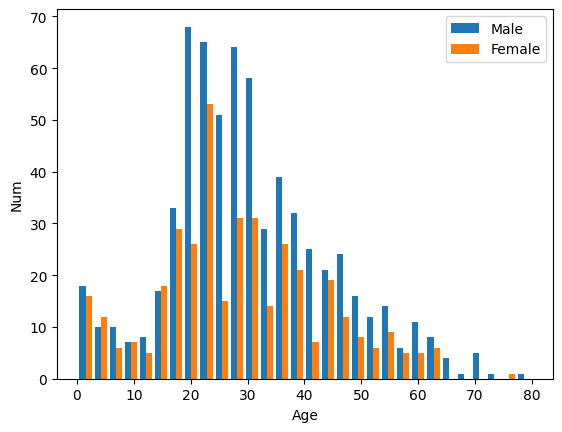

In [4]:
# 船上的乘客各年齡層的男女比例
# 小於20歲的男女人數比例接近，但若超過20歲（含）的乘客，則男性比例則比女性多。
figure = plt.figure()
plt.hist([data[data['Sex']=='male']['Age'], data[data['Sex']=='female']['Age']], stacked=False, bins = 30,label = ['Male','Female'])
plt.xlabel('Age')
plt.ylabel('Num')
plt.legend()

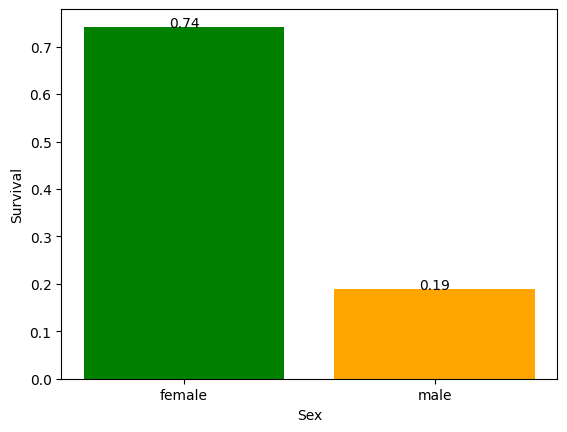

In [5]:
# 以人數來看不同性別的存活率，發現男性的存活率只有19%，而女性則高達74%。
result = data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
plt.bar(result['Sex'], result['Survived'], color=['green', 'orange'])
plt.xlabel('Sex')
plt.ylabel('Survival')
for i, value in enumerate(result['Survived']):
    plt.text(i, value, str(round(value, 2)), ha='center')
plt.show()

<Axes: >

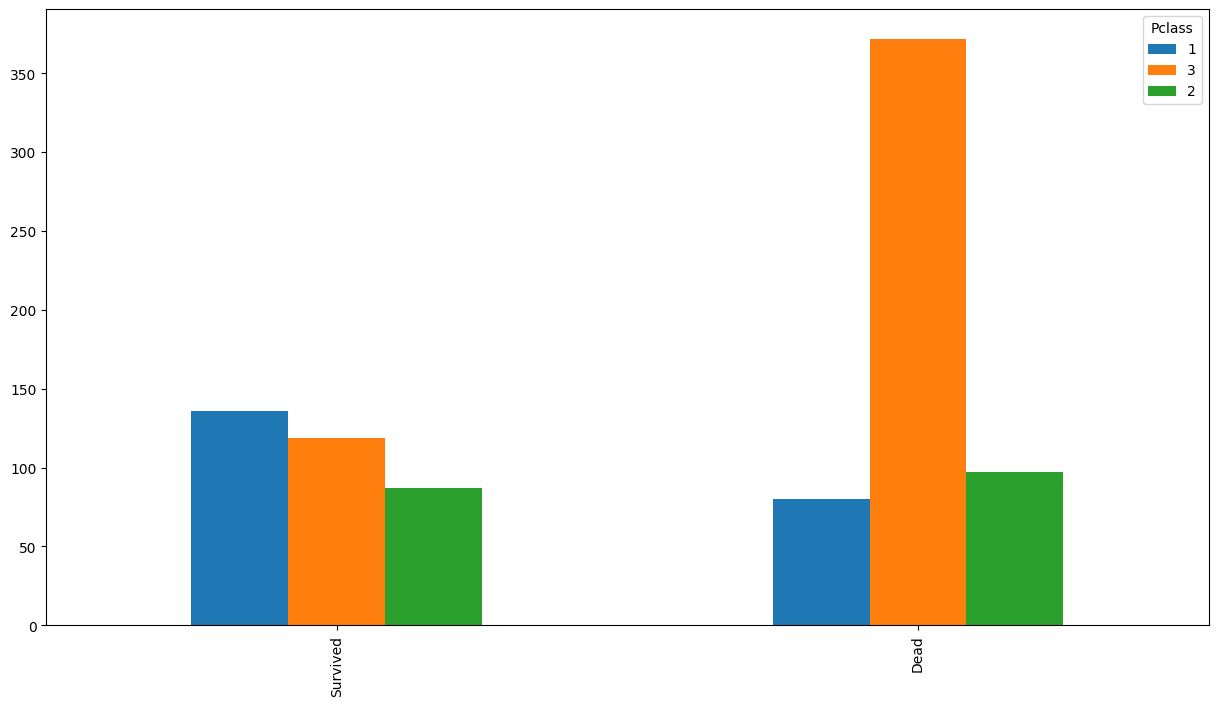

In [6]:
# 船票等級與存活的關係
## 從人數來看不同船票等級的存活率：明顯看出等級3的乘客最多，死亡者也大部份為等級3的乘客。
survived_pclass = data[data['Survived']==1]['Pclass'].value_counts()
dead_pclass = data[data['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_pclass,dead_pclass])
df.index = ['Survived','Dead']
df.plot(kind='bar',figsize=(15,8))

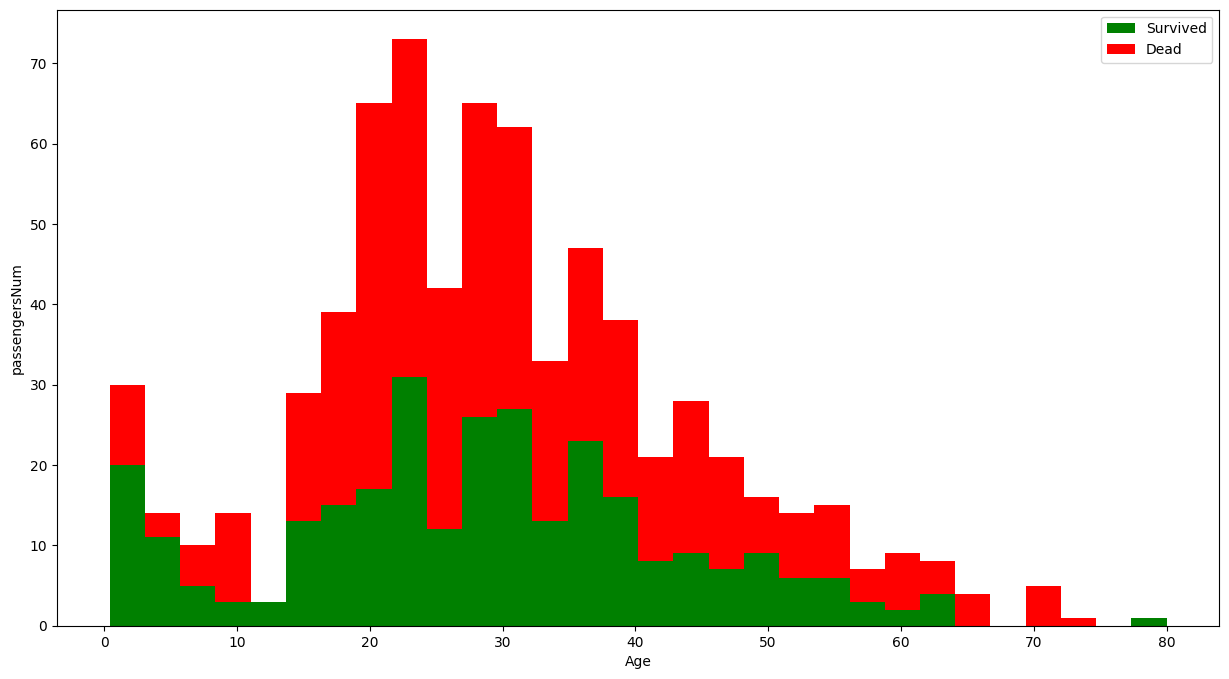

In [7]:
# 不同年齡層與倖存的關係
# 從下圖可看出年齡愈偏向兩極（較年長或較年幼）則存活率愈高，其中年齡越小越明顯。
figure = plt.figure(figsize=(15,8))
plt.hist([data[data['Survived']==1]['Age'], data[data['Survived']==0]['Age']], stacked=True, color = ['g','r'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('passengersNum')
plt.legend()

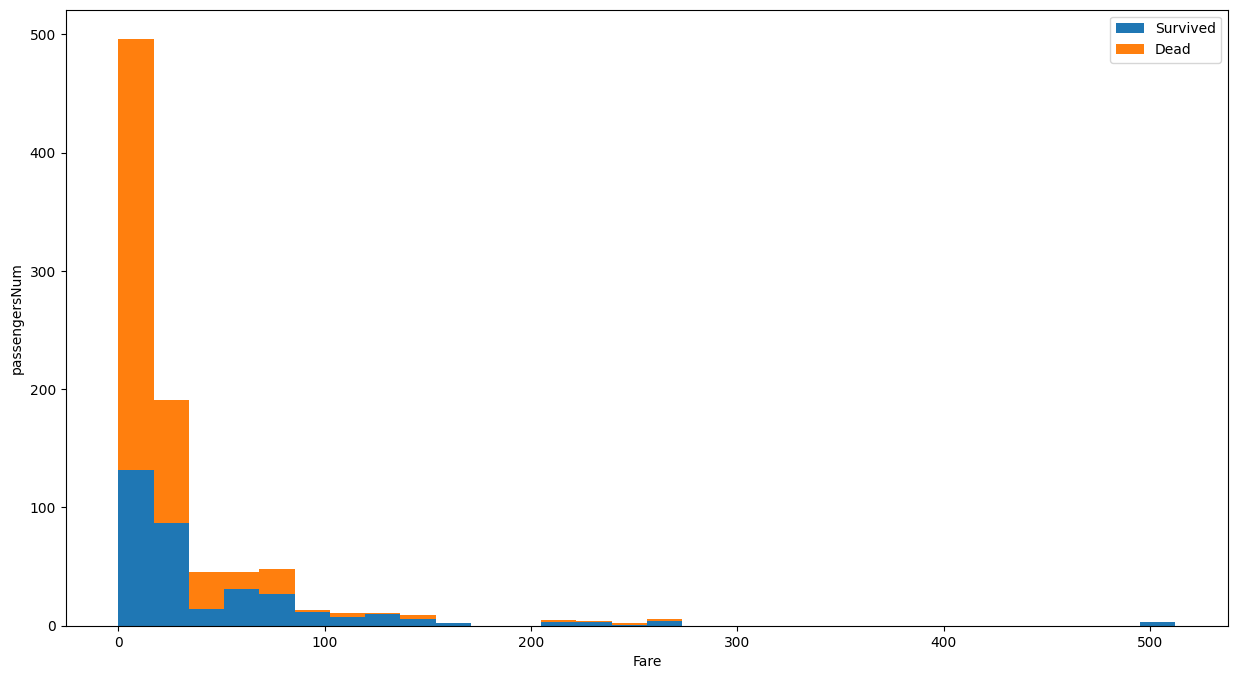

In [8]:
# 不同票價與存活的關係
# 經由下方結果發現，票價愈高則存活率愈大。
figure = plt.figure(figsize=(15,8))
plt.hist([data[data['Survived']==1]['Fare'],data[data['Survived']==0]['Fare']], stacked=True, bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('passengersNum')
plt.legend()

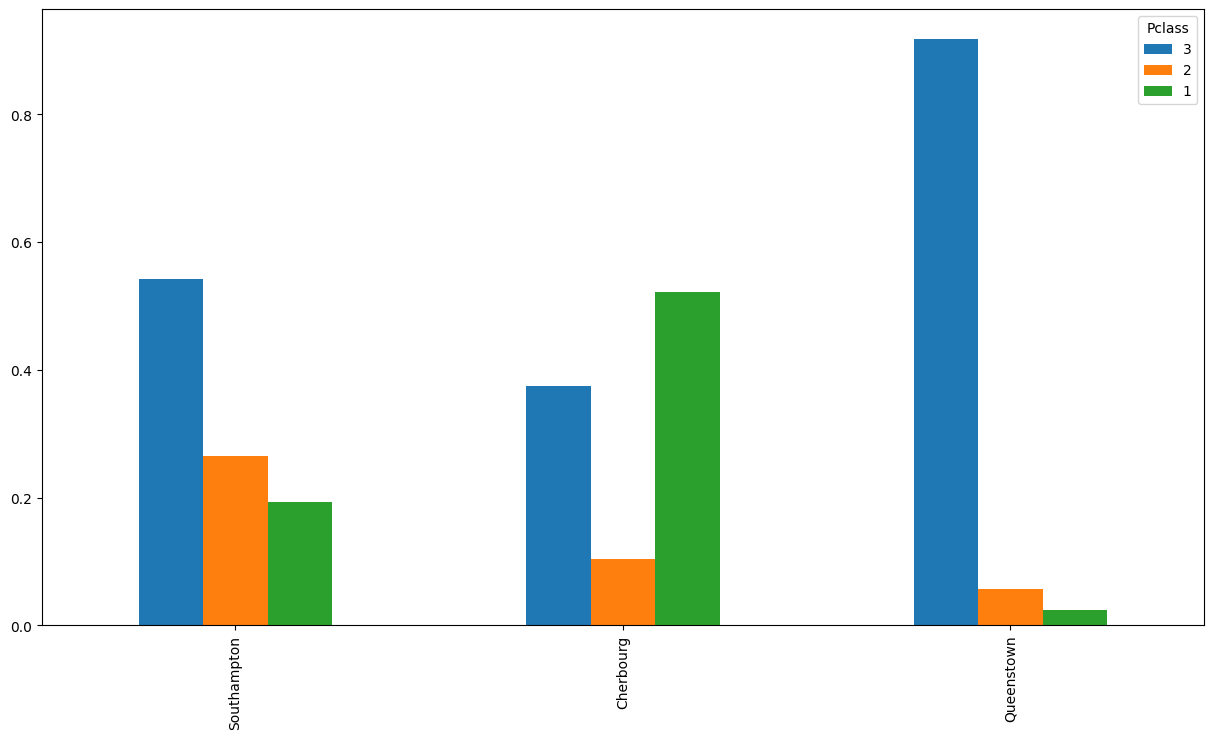

In [9]:
# 上岸港口與船票等級的關係
# 從以下統計結果可看出不同港口乘客有不同的經濟狀況，C港口大多購買等級最高的票，Q港口則是購買為低等級的票
total_Pclass_S = data[data['Embarked']=='S']['Pclass'].count()
total_Pclass_C = data[data['Embarked']=='C']['Pclass'].count()
total_Pclass_Q = data[data['Embarked']=='Q']['Pclass'].count()
Embarked_S = data[data['Embarked']=='S']['Pclass'].value_counts() / total_Pclass_S
Embarked_C = data[data['Embarked']=='C']['Pclass'].value_counts() / total_Pclass_C
Embarked_Q = data[data['Embarked']=='Q']['Pclass'].value_counts() / total_Pclass_Q  
df = pd.DataFrame([Embarked_S,Embarked_C,Embarked_Q])
df.index = ['Southampton','Cherbourg','Queenstown']
df.plot(kind='bar', stacked=False, figsize=(15, 8))
plt.show()

In [10]:
# Age
condition =  (data["Age"].isnull()) & ( (data['Name'].str.contains("Ms.")) | (data['Name'].str.contains("Miss.")) )
condition2 = ( (data['Name'].str.contains("Ms.")) | (data['Name'].str.contains("Miss.")) )
data.loc[condition,'Age'] = data.loc[condition,'Age'].fillna(data.loc[condition2,'Age'].median())

condition_1 =  (data["Age"].isnull()) & ( (data['Name'].str.contains("Mr.")) | (data['Name'].str.contains("Sir.")) | (data['Name'].str.contains("Major")) )
condition_2 =  ( (data['Name'].str.contains("Mr.")) | (data['Name'].str.contains("Sir.")) | (data['Name'].str.contains("Major")) )
data.loc[condition_1,'Age'] = data.loc[condition_1,'Age'].fillna(data.loc[condition_2,'Age'].median())

condition3 =  (data["Age"].isnull()) & (data['Name'].str.contains("Master.") )
data.loc[condition3,'Age'] = data.loc[condition3,'Age'].fillna(data[data['Name'].str.contains("Master.")]["Age"].median())

condition4 =  (data["Age"].isnull()) & ( data['Name'].str.contains("Dr\.") )
data.loc[condition4,'Age'] = data.loc[condition4,'Age'].fillna(data[data['Name'].str.contains("Dr\.")]["Age"].median())

data[data["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [11]:
# #Title
data['Title'] = data['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
data['Title'] = data['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
data['Title'] = data['Title'].replace(['Mlle','Ms'], 'Miss')
data['Title'] = data['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
df = pd.get_dummies(data['Title'],prefix='Title')
data = pd.concat([data,df],axis=1)

# # #Name_length
data['Name_Len'] = data['Name'].apply(lambda x: len(x))
data['Name_Len'] = pd.qcut(data['Name_Len'],5)

# #Dead_female_family & Survive_male_family
data['Surname'] = data['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(data[(data.Sex=='female') & (data.Age>=16)
                              & (data.Survived==0) & ((data.Parch>0) | (data.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(data[(data.Sex=='male') & (data.Age>=16)
                              & (data.Survived==1) & ((data.Parch>0) | (data.SibSp > 0))]['Surname'].values))
data['Dead_female_family'] = np.where(data['Surname'].isin(dead_female_surname),0,1)
data['Survive_male_family'] = np.where(data['Surname'].isin(survive_male_surname),0,1)
data = data.drop(['Name','Surname'],axis=1)

#ticket
data['Ticket_Lett'] = data['Ticket'].apply(lambda x: str(x)[0])
data['Ticket_Lett'] = data['Ticket_Lett'].apply(lambda x: str(x))

data['High_Survival_Ticket'] = np.where(data['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
data['Low_Survival_Ticket'] = np.where(data['Ticket_Lett'].isin(['A','W','3','7']),1,0)
data = data.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
data.Embarked = data.Embarked.fillna('C')
df = pd.get_dummies(data['Embarked'],prefix='Embarked')
data = pd.concat([data,df],axis=1).drop('Embarked',axis=1)

#FamilySize
data['FamilySize'] = np.where(data['SibSp']+data['Parch']==0, 'Alone',
                                    np.where(data['SibSp']+data['Parch']<=3, 'Small', 'Big'))
df = pd.get_dummies(data['FamilySize'],prefix='FamilySize')
data = pd.concat([data,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

#Cabin
data = data.drop('Cabin',axis=1)

#PClass
df = pd.get_dummies(data['Pclass'],prefix='Pclass')
data = pd.concat([data,df],axis=1).drop('Pclass',axis=1)

#Sex
df = pd.get_dummies(data['Sex'],prefix='Sex')
data = pd.concat([data,df],axis=1).drop('Sex',axis=1)

#Fare
data['Fare'].fillna(data['Fare'].dropna().median(),inplace=True)
data['Low_Fare'] = np.where(data['Fare']<=8.662,1,0)
data['High_Fare'] = np.where(data['Fare']>=26,1,0)
data = data.drop('Fare',axis=1)

In [12]:
# data.info()

In [13]:
# data.columns

In [14]:
features = data.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(data[feature])
    data[feature] = le.transform(data[feature])

In [15]:
from sklearn.model_selection import cross_val_score

X_all = data.iloc[:891,:].drop(["PassengerId","Survived"], axis=1)
Y_all = data.iloc[:891,:]["Survived"]
X_test = data.iloc[891:,:].drop(["PassengerId","Survived"], axis=1)

logisticRegression = LogisticRegression()
svc = SVC()
kNeighborsClassifier = KNeighborsClassifier(n_neighbors = 3)
decisionTreeClassifier = DecisionTreeClassifier()
randomForestClassifier = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
xGBClassifier = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.03)
lGBMClassifier = LGBMClassifier(max_depth=3, n_estimators=500, learning_rate=0.02)
all = [logisticRegression, svc, kNeighborsClassifier, decisionTreeClassifier, randomForestClassifier, gradientBoostingClassifier, xGBClassifier, lGBMClassifier]

kfold = 10
results = []
for classifier in all :
    results.append(cross_val_score(classifier, X_all.values, y = Y_all.values, scoring = "accuracy", cv = kfold, n_jobs=4))

means = []
std = []
for result in results:
    means.append(result.mean())
    std.append(result.std())

ag = ["邏輯斯回歸(LogisticRegression)：","支援向量機(SVC)：",'K-近鄰演算法(KNN)：',
      '決策樹(DecisionTreeClassifier)：',"隨機森林(RandomForestClassifier)：",
      "GradientBoostingClassifier：","XGBClassifier：", "LGBMClassifier："]
res = pd.DataFrame({"CrossValMeans":means,"CrossValerrors": std,
                       "Algorithm":ag})


In [16]:
for i in range(8):
    print(ag[i],means[i])

邏輯斯回歸(LogisticRegression)： 0.8832584269662922
支援向量機(SVC)： 0.6386267166042447
K-近鄰演算法(KNN)： 0.7991385767790261
決策樹(DecisionTreeClassifier)： 0.8395131086142322
隨機森林(RandomForestClassifier)： 0.8687265917602996
GradientBoostingClassifier： 0.8956429463171037
XGBClassifier： 0.8900124843945069
LGBMClassifier： 0.8978651685393257


In [17]:
# modele = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
# modele = LGBMClassifier(max_depth=3, n_estimators=500, learning_rate=0.02)
# modele = LogisticRegression()
modele = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
# modele = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.03)

In [18]:
modele.fit(X_all.values, Y_all.values)
Y_test = modele.predict(X_test.values).astype(int)

# 輸出結果至gender_submission.csv
sout = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": Y_test
    })
sout.to_csv('gender_submission.csv', index=False)